### 회귀 실습 - 자전거 대여 수요 예측

- https://www.kaggle.com/competitions/bike-sharing-demand/data

- 데이터 설명

  - datetime - hourly date + timestamp  

  - season -  1 = spring, 2 = summer, 3 = fall, 4 = winter

  - holiday - whether the day is considered a holiday

  - workingday - whether the day is neither a weekend nor holiday

  - weather
       - 1: Clear, Few clouds, Partly cloudy

       - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

       - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

       - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

  - temp - temperature in Celsius

  - atemp - "feels like" temperature in Celsius → 체감온도

  - humidity - relative humidity → 상대습도

  - windspeed - wind speed

  - casual - number of non-registered user rentals initiated

  - registered - number of registered user rentals initiated

  - count - number of total rentals → **Target**

#### 데이터 클렌징 및 가공과 데이터 시각화

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

bike_df = pd.read_csv('/content/bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- datetime칼럼이 object형으로 년-월-일 시:분:초 형식으로 되어있기 때문에 가공이 필요하다

In [3]:
#연, 월, 날, 시간 칼럼 추출
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

bike_df['year'] = bike_df.datetime.apply(lambda x: x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [4]:
bike_df = bike_df.drop('datetime', axis=1)

In [5]:
#count칼럼은 casual+registered 이기 때문에 이 두 칼럼이 따로 필요하지는 않다.
#오히려 상관도가 높아 예측을 저해할 수 있으므로 드랍한다

bike_df = bike_df.drop(['casual', 'registered'], axis=1)

In [6]:
bike_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


- 주요 칼럼별로 count가 어떻게 분포되어있는지 시각화해보자

- 8개의 칼럼을 한번에 시각화하기 위해 subplots() 사용

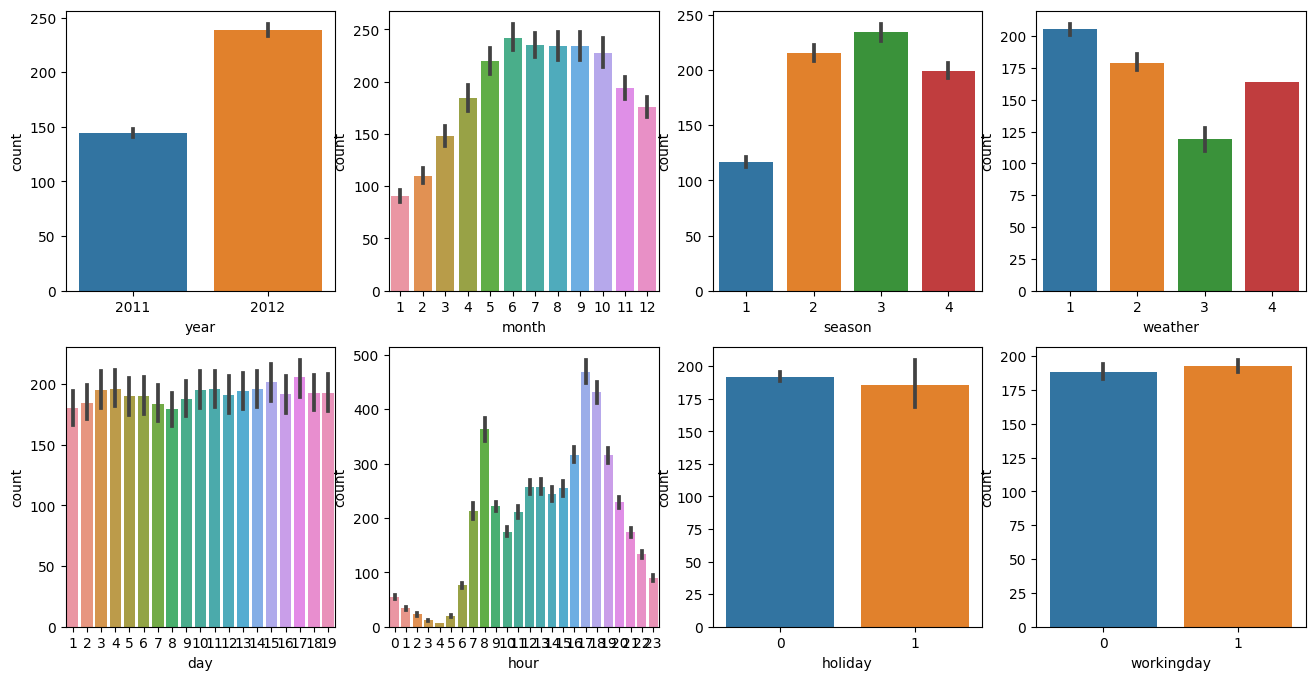

In [7]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']

for i, feature in enumerate(cat_features):
  row = int(i/4)
  col = i%4
  sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

year: 2012년이 2011년보다 상대적으로 높다, 특별한 의미보다는 시간이 지날수록 대여 횟수가 증가한 것이라 볼 수 있음

month: 1,2,3월이 낮고 6,7,8,9월이 높음

season: 봄(1), 겨울(4)이 낮고 여름(2), 가을(3)이 높다

weather: 맑거나 약간 안개가 있는 날(1)이 높음

hour: 22~6시는 낮고 오전 출근 시간인 8시와 퇴근 시간인 17,18시가 높다

day: 격차가 크진 않다

holiday/workingday: 주중일 경우(holiday는 0, workingday는 1)가 약간 더 높다

#### 여러 회귀 모델로 예측 성능 측정

- RMSLE(Root Mean Squared Log Error): 오류값의 로그에 대한 RMSE

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

def rmse(y, pred):
  return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
  rmsle_val = rmsle(y, pred)
  rmse_val = rmse(y, pred)
  mae_val = mean_absolute_error(y, pred)
  print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

- 로그 변환, 피처 인코딩

  - 결과값이 정규 분포로 되어있는지 확인
  
  - 범주형 회귀 모델의 경우 원-핫 인코딩을 진행

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop('count', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


데이터셋의 크기를 감안하면 비교적 큰 예측 오류가 나옴

실제값과 오류값이 얼마나 차이나는지 데이터프레임의 칼럼으로 만들어서 확인해보자

In [11]:
def get_top_error_data(y_test, pred, n_tops=5):
  results_df = pd.DataFrame(y_test.values, columns=['real_count'])
  results_df['predicted_count'] = np.round(pred)
  results_df['diff'] = np.abs(results_df['real_count'] - results_df['predicted_count'])

  print(results_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


- RMSE가 높게 나온 이유

  타겟값이 큰 데이터들에 대해서 예측 오류가 크게 나오면서 전체 데이터의 RMSE가 크게 나왔다

  비교적 정확한 예측 성능을 가진 모델이어도 타겟값이 작은 데이터에 대해서 예측 오류가 나는 것보다 타겟값이 큰 데이터에 대해서 예측 오류가 나는 것이 임팩트가 더 크다 >> 따라서 RMSE값이 크게 나오는 것이다

  이 데이터셋에서는 큰 타겟값을 가지는 데이터에 대해 예측 정확도가 높지 않고 이를 상쇄하기 위해 log를 씌워 해결하는 것

회귀에서 이렇게 큰 예측 오류가 발생할 때는 타겟값의 분포가 왜곡되지는 않았는지 확인해야 한다

https://velog.io/@seulki971227/RMSLE%EB%A5%BC-%EC%82%AC%EC%9A%A9%ED%95%98%EB%8A%94-%EC%9D%B4%EC%9C%A0%EB%8A%94-%EB%AC%B4%EC%97%87%EC%9D%BC%EA%B9%8C-feat.-Kaggle-Bike-Sharing-Demand

<Axes: >

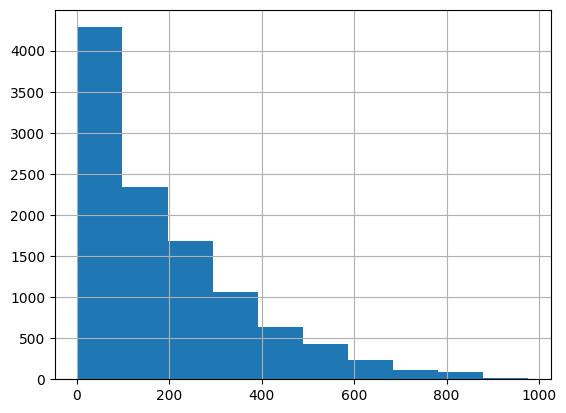

In [12]:
y_target.hist()

0~200 사이에 왜곡되어있다

로그를 적용해 정규 분포 형태로 바꾸고 변경된 타겟값을 기반으로 학습하고 예측한 값은 다시 expm1() 함수를 이용하여 원래 scale값으로 복구시키면 된다

- 로그 변환의 이유

  : 로그함수의 특징인 x값이 커짐에 따라 함수의 기울기값은 급격히 작아진다. 큰 x값들에 대해서는 y값이 크게 차이나지 않고 이에 따라 넓은 범위를 가지는 x를 비교적 작은 y값의 구간 내에 모이게 된다. 따라서 데이터 분포가 밀집되어 있는 부분은 퍼지게, 퍼져있는 부분은 모이게 만들 수 있다. >> 따라서 한쪽으로 몰려있는 데이터분포에 로그 변환을 취하면 넓게 퍼질 수 있는 것

<Axes: >

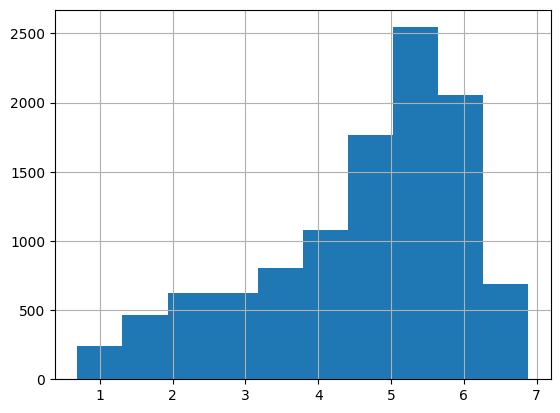

In [13]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

그 전보다는 왜곡 정도가 향상됌

In [14]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


RMSLE는 줄었지만 RMSE는 오히려 더 늘어남

이번엔 개별 피처에 인코딩을 적용해보자

<Axes: >

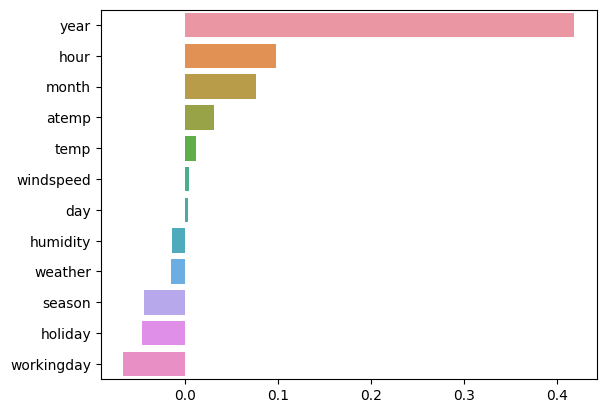

In [15]:
#각 피처의 회귀계수값 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

year, month는 숫자값 형태로 의미를 갖고 있지만 개별 숫자값의 크기가 의미있는 것은 아니다

이처럼 숫자형 범주값을 선형 회귀에 사용할 경우 회귀 계수를 연산할 때 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있다

따라서, 원-핫 인코딩을 적용하여 변환해야 한다

In [16]:
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday',
                                                     'workingday', 'season', 'weather'])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                     test_size=0.3, random_state=0)

#각 모델마다 학습, 테스트 데이터셋을 입력하면 성능 평가 수치를 반환해주는 함수 생성
def get_model_predict(model, X_train, X_test, y_train, y_test, is_exmp1=False):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  if is_exmp1:
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###', model.__class__.__name__, '###')
  evaluate_regr(y_test, pred)

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_exmp1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<Axes: >

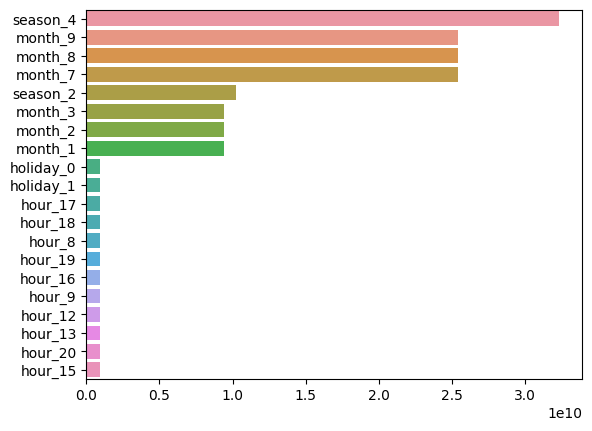

In [20]:
#원-핫 인코딩으로 피처가 늘어났으므로 회귀 계수 상위 20개 피처를 추출해보자
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

원-핫 인코딩을 통해 선형 회귀의 예측 성능도 많이 향상되고 피처들의 영향도도 달라졌다.

반드시는 아니지만 선형 회귀의 경우, **중요 범주형 피처들을 원-핫 인코딩으로 변환하는 것**은 성능에 중요한 영향을 미칠 수 있다

- 이번에는 회귀 트리를 이용하여 예측을 수행하자

  - 인코딩된 데이터셋 그대로 랜포, GBM, XGBoost, LightGBM을 적용

In [22]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_red = RandomForestRegressor()
gbm_reg = GradientBoostingRegressor()
xgb_reg = XGBRegressor()
lgbm_reg = LGBMRegressor()

for model in [rf_red, gbm_reg, xgb_reg, lgbm_reg]:
  get_model_predict(model, X_train.values, X_test.values, y_train.values,
                    y_test.values, is_exmp1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.884, MAE: 31.415
### GradientBoostingRegressor ###
RMSLE: 0.484, RMSE: 96.512, MAE: 59.713
### XGBRegressor ###
RMSLE: 0.340, RMSE: 52.002, MAE: 31.603
### LGBMRegressor ###
RMSLE: 0.332, RMSE: 51.381, MAE: 31.833
